# Preprocessing Pandas

In [ ]:
import pandas as pd
sample_submission = pd.read_csv("understanding_cloud_organization/sample_submission.csv")
train = pd.read_csv("understanding_cloud_organization/train_320.csv")

In [ ]:
train['Image_name'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['Label_name'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train.drop('Image_Label',axis=1,inplace=True)
train = train.pivot('Image_name','Label_name','EncodedPixels')

In [ ]:
train.head()

# Affichage Image

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img=mpimg.imread('./understanding_cloud_organization/train_images_320/009e2f3.jpg')
img2=mpimg.imread('./understanding_cloud_organization/train_images_320_Black_Fish_Gravel_Sugar_Flower/009e2f3.jpg')

print(img)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(img2)



# DATA LOADING

In [ ]:
from transformations import MoveAxis, Normalize01

In [ ]:
from transformations import Compose, DenseTarget
from transformations import MoveAxis, Normalize01
from customdatasets import SegmentationDataSet
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib

# root directory
root = pathlib.Path.cwd() / 'understanding_cloud_organization'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
inputs = get_filenames_of_path(root / 'train_images_320')
targets = get_filenames_of_path(root / 'train_images_320_Black_Fish_Gravel_Sugar_Flower')
    

# training transformations and augmentations
transforms = Compose([
    DenseTarget(),
    Normalize01(),
    MoveAxis(),
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)


targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

    

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms)
print(len(dataset_train))

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=4,
                                 shuffle=False)
print(dataloader_training)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=4,
                                   shuffle=False)



In [2]:
x, y = next(iter(dataloader_training))
w, z = next(iter(dataloader_training))
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
print(f'y = min: {y.min()}; max: {y.max()}')


x = shape: torch.Size([4, 3, 320, 480]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([4, 4, 320, 480]); class: tensor([0., 1.]); type: torch.float32
y = min: 0.0; max: 1.0


(4, 320, 480)
[[[0.16078432 0.1882353  0.2627451 ]
  [0.10980392 0.13725491 0.21176471]
  [0.44705883 0.47058824 0.5568628 ]
  ...
  [0.03137255 0.06666667 0.1882353 ]
  [0.03137255 0.06666667 0.18039216]
  [0.03137255 0.06666667 0.18039216]]

 [[0.05098039 0.07450981 0.16078432]
  [0.11372549 0.13725491 0.22352941]
  [0.11372549 0.13725491 0.23137255]
  ...
  [0.03529412 0.07058824 0.19215687]
  [0.03529412 0.07058824 0.18431373]
  [0.03529412 0.07058824 0.18431373]]

 [[0.07843138 0.10196079 0.20392157]
  [0.10588235 0.12941177 0.23137255]
  [0.05490196 0.07843138 0.18039216]
  ...
  [0.03921569 0.07450981 0.19607843]
  [0.03529412 0.07058824 0.19215687]
  [0.03529412 0.07058824 0.18431373]]

 ...

 [[0.21960784 0.23921569 0.3137255 ]
  [0.15294118 0.17254902 0.24705882]
  [0.16078432 0.18039216 0.25490198]
  ...
  [0.0627451  0.07843138 0.18431373]
  [0.0627451  0.07843138 0.18431373]
  [0.23529412 0.2509804  0.35686275]]

 [[0.18039216 0.2        0.27450982]
  [0.12156863 0.1411764

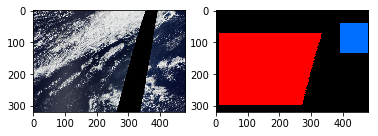

In [3]:
import torchvision.utils
from skimage.io import imread
import numpy as np
import helper
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

x, y = next(iter(dataloader_training))

true_inputs = x

true_labels = y
print(true_labels[0].numpy().shape)

def reverse_transform(inp):
    inp = inp.numpy()
    inp = np.moveaxis(inp, -1, 0)
    inp = np.moveaxis(inp, -1, 0)
    input_asarray = np.clip(inp, 0, 1)
    input_asarray = (input_asarray * 255).astype(np.uint8)
    return input_asarray

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in true_inputs]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x.cpu(), "xD") for x in true_labels]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(input_images_rgb[0])
axarr[1].imshow(target_masks_rgb[0])

## MODEL UNET

In [4]:
import torch
from unet import *
model = UNet(in_channels=3,
             out_channels=4,
             n_blocks=6,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).cuda()

x = torch.randn(size=(1, 3, 320, 480), dtype=torch.float32).cuda()

with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([1, 4, 320, 480])


In [ ]:
from torchsummary import summary
summary = summary(model, (3, 320, 480))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 480]             896
              ReLU-2         [-1, 32, 320, 480]               0
       BatchNorm2d-3         [-1, 32, 320, 480]              64
            Conv2d-4         [-1, 32, 320, 480]           9,248
              ReLU-5         [-1, 32, 320, 480]               0
       BatchNorm2d-6         [-1, 32, 320, 480]              64
         MaxPool2d-7         [-1, 32, 160, 240]               0
         DownBlock-8  [[-1, 32, 160, 240], [-1, 32, 320, 480]]               0
            Conv2d-9         [-1, 64, 160, 240]          18,496
             ReLU-10         [-1, 64, 160, 240]               0
      BatchNorm2d-11         [-1, 64, 160, 240]             128
           Conv2d-12         [-1, 64, 160, 240]          36,928
             ReLU-13         [-1, 64, 160, 240]               0
      BatchNorm2d-14    

In [ ]:
shape = 1920


def compute_max_depth(shape, max_depth=10, print_out=True):
    shapes = []
    shapes.append(shape)
    for level in range(1, max_depth):
        if shape % 2 ** level == 0 and shape / 2 ** level > 1:
            shapes.append(shape / 2 ** level)
            if print_out:
                print(f'Level {level}: {shape / 2 ** level}')
        else:
            if print_out:
                print(f'Max-level: {level - 1}')
            break

    return shapes


out = compute_max_depth(shape, print_out=True, max_depth=10)


Level 1: 960.0
Level 2: 480.0
Level 3: 240.0
Level 4: 120.0
Level 5: 60.0
Level 6: 30.0
Level 7: 15.0
Max-level: 7


In [ ]:
low = 10
high = 512
depth = 8


def compute_possible_shapes(low, high, depth):
    possible_shapes = {}
    for shape in range(low, high + 1):
        shapes = compute_max_depth(shape,
                                   max_depth=depth,
                                   print_out=False)
        if len(shapes) == depth:
            possible_shapes[shape] = shapes

    return possible_shapes
possible_shapes = compute_possible_shapes(low, high, depth)
possible_shapes


{256: [256, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0],
 384: [384, 192.0, 96.0, 48.0, 24.0, 12.0, 6.0, 3.0],
 512: [512, 256.0, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0]}

# TRAIN ET RUN

In [ ]:
from train import Trainer

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# criterion
criterion = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=10,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


[0.5049351434163729]


[0.5049351434163729, 0.399446021285113]


[0.5049351434163729, 0.399446021285113, 0.3872392166026333]


[0.5049351434163729, 0.399446021285113, 0.3872392166026333, 0.3718106218347472]


[0.5049351434163729, 0.399446021285113, 0.3872392166026333, 0.3718106218347472, 0.3567952465591826]


# SAVE THE MODEL

In [ ]:
model_name =  'cloud.pt'
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)

# LEARNING RATE

In [ ]:
from lr_rate_finder import *
lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=1000)

In [ ]:
lrf.plot()


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
fig = plt.show(training_losses, validation_losses)
print(training_losses)
print(validation_losses)

In [ ]:
from visual import plot_training
fig = plot_training(training_losses, validation_losses, lr_rates, gaussian=True, sigma=1, figsize=(10, 4))

In [ ]:
import math
from sklearn.model_selection import train_test_split

import pathlib

random_seed = 42

# root directory
root = pathlib.Path.cwd() / 'understanding_cloud_organization'
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
inputs = get_filenames_of_path(root / 'train_images_320')
targets = get_filenames_of_path(root / 'train_images_320_Black_Fish_Gravel_Sugar_Flower')

model.eval()   # Set model to evaluate mode

train_size = 0.8  # 80:20 split
inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

test_dataset = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

test_loader = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=False)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=False)
        
x, y = next(iter(dataloader_training))
true_inputs = x.to(device)
true_labels = y.to(device)

pred = model(true_inputs).cpu()
out_pred = torch.softmax(pred, dim=1).detach()


true_inputs = true_inputs.cpu()
true_labels = true_labels.cpu()



import torchvision.utils
from skimage.io import imread
import numpy as np
import helper

def reverse_transform(inp):
    inp = inp.numpy()
    inp = np.moveaxis(inp, -1, 0)
    inp = np.moveaxis(inp, -1, 0)
    input_asarray = np.clip(inp, 0, 1)
    input_asarray = (input_asarray * 255).astype(np.uint8)
    return input_asarray

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in true_inputs]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x.cpu(), "xD") for x in true_labels]

pred_rgb = [helper.masks_to_colorimg(x, "xD") for x in out_pred]

f, axarr = plt.subplots(2,3)
axarr[0][0].imshow(input_images_rgb[0])
axarr[0][1].imshow(target_masks_rgb[0])
axarr[0][2].imshow(pred_rgb[0])
axarr[1][0].imshow(input_images_rgb[1])
axarr[1][1].imshow(target_masks_rgb[1])
axarr[1][2].imshow(pred_rgb[1])